# Visualizing NE types in PILE-NER corpus by plotting their word embeddings

In [1]:
import sys
sys.path.append("/Users/andrew/ExpertAI/MSEQA_for_NER/src/MSEQA_4_NER")
from data_handlers import data_handler_pileNER

import gensim # to use pre-trained word2vec model
import gensim.downloader as gensim_downloader

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd

import json

In [2]:
path_to_ne_types_list = '../data_handlers/questions/pileNER/ne_types_list.json'
with open(path_to_ne_types_list, 'r') as file:
        ne_types_list = json.load(file)
print(len(ne_types_list))
print(ne_types_list)

455
['person', 'organization', 'location', 'concept', 'product', 'variable', 'date', 'medical condition', 'object', 'technology', 'chemical', 'software', 'event', 'number', 'disease', 'attribute', 'protein', 'group', 'material', 'measurement', 'other', 'function', 'entity type', 'nationality', 'country', 'class', 'process', 'title', 'animal', 'component', 'condition', 'substance', 'food', 'city', 'activity', 'type', 'company', 'time', 'method', 'property', 'organism', 'drug', 'medical procedure', 'treatment', 'profession', 'cell type', 'anatomical structure', 'job title', 'data', 'quantity', 'sports team', 'biological process', 'data type', 'programming language', 'occupation', 'file', 'body part', 'medical treatment', 'language', 'chemical compound', 'entity', 'gene', 'state', 'law', 'action', 'website', 'library', 'facility', 'publication', 'tool', 'field of study', 'compound', 'document', 'organ', 'abbreviation', 'character', 'brand', 'device', 'operating system', 'service', 'techni

In [3]:
# downloading word2vec pre-trained model
all_pretrained_word_embeddings = gensim_downloader.load("word2vec-google-news-300")
print(type(all_pretrained_word_embeddings))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [6]:
print(f"Each word embedding is a vector of shape: {all_pretrained_word_embeddings[0].shape}")
print(f"of type {type(all_pretrained_word_embeddings)}")
print(f"each vector is of type {type(all_pretrained_word_embeddings[0])}") # access by index
# print(word_emb["apple"]) # access by word-lookup

Each word embedding is a vector of shape: (300,)
of type <class 'gensim.models.keyedvectors.KeyedVectors'>
each vector is of type <class 'numpy.ndarray'>


In [7]:
for ne in ne_types_list:
    for word in ne.split():
        if word not in all_pretrained_word_embeddings:
            print(f"\"{word}\" not in embeddings")

"of" not in embeddings
"anatomical_structure" not in embeddings
"cryptocurrency" not in embeddings
"of" not in embeddings
"biological_process" not in embeddings
"body_part" not in embeddings
"demonym" not in embeddings
"of" not in embeddings
"gpe" not in embeddings
"gene/protein" not in embeddings
"medical_condition" not in embeddings
"work_of_art" not in embeddings
"anatomicalstructure" not in embeddings
"norp" not in embeddings
"of" not in embeddings
"job_title" not in embeddings
"organisation" not in embeddings
"chemical_substance" not in embeddings
"medicalcondition" not in embeddings
"fieldterminology" not in embeddings


##### Defining a dictionary to map some NE types in words belonging to all_pretrained_word_embeddings

In [8]:
ne_mapping = {"cryptocurrency": ["crypto", "currency"], 
                "demonym": ["inhabitants", "natives"], 
                "gpe": ["geo", "political", "entity"],
                "anatomicalstructure": ["anatomical", "structure"],
                "norp": ["nationalities", "religious", "political", "group"],
                "organisation": ["organization"],
                "medicalcondition": ["medical", "condition"],
                "fieldterminology": ["field", "terminology"]
                }

In [9]:
def get_embedding_for_ne(word_emb_model, ne, ne_mapping):
    """ 
    Given a NE type return its embedding vector.
    Since a NE type may be composed of multiple words like "medical condition" we take the average of its sub-words embeddings.
    If a NE type/word is not present in word2vec embeddings we map it to some other existings words (e.g. a synonym)
    """
    ne_words = ne.split()
    if len(ne_words) == 1:
        if ne not in word_emb_model:
            # try splitting using _ or /
            # e.g work_of_art or gene/protein
            if "/" in ne:
                ne_words = ne.split("/")
            elif "_" in ne:
                ne_words = ne.split("_")
            else:    
                if ne in ne_mapping:
                    ne_words = ne_mapping[ne]
                else:
                    print(f"\"{ne}\" not in word_emb_model!")
                    return np.zeros_like(word_emb_model[0])
        else:
            return word_emb_model[ne]
            
    tot_sum = np.zeros_like(word_emb_model[0])
    n_sub_words = 0
    for sub_word in ne_words:
        if sub_word in word_emb_model:
            tot_sum += word_emb_model[sub_word]
            n_sub_words += 1
        else:
            print(f"\"{sub_word}\" not found while processing ne: \"{ne}\", will be skipped")
    average = tot_sum / n_sub_words
    return average

In [10]:
for ne in ne_types_list:
    if get_embedding_for_ne(all_pretrained_word_embeddings, ne, ne_mapping) is None:
        print(ne)

"of" not found while processing ne: "field of study", will be skipped
"of" not found while processing ne: "work of art", will be skipped
"of" not found while processing ne: "group of people", will be skipped
"of" not found while processing ne: "work_of_art", will be skipped
"of" not found while processing ne: "unit of measurement", will be skipped


In [11]:
ne_types_embeddings = np.array([get_embedding_for_ne(all_pretrained_word_embeddings, ne, ne_mapping) for ne in ne_types_list])

"of" not found while processing ne: "field of study", will be skipped
"of" not found while processing ne: "work of art", will be skipped
"of" not found while processing ne: "group of people", will be skipped
"of" not found while processing ne: "work_of_art", will be skipped
"of" not found while processing ne: "unit of measurement", will be skipped


In [12]:
print(ne_types_embeddings.shape)

(455, 300)


### Constructing KeyedVector object to store embedding for each NE type

In [22]:
from gensim.models import KeyedVectors

In [23]:
ne_embeddings_keyedvector = KeyedVectors(vector_size=ne_types_embeddings.shape[-1], count=ne_types_embeddings.shape[0])
for ne_name, ne_emb in zip(ne_types_list, ne_types_embeddings):
    ne_embeddings_keyedvector.add_vector(key=ne_name, vector=ne_emb)

In [24]:
ne_embeddings_keyedvector.key_to_index['person']
ne_embeddings_keyedvector.index_to_key[0]

'person'

In [ ]:
def retrieve_most_similar(query_words_list, all_words_embeddings_kv, my_NE_kv):
    
    # get the word embeddings for the query words
    query_emb = all_words_embeddings_kv[query_words_list] # shape: |Q| x 300
    
    # get cosine similarity between queries and my NE embeddings
    cos_sim = cosine_similarity(query_emb, my_NE_kv.vectors) # shape: |Q| x |V_r|=455

    # cos_sim = np.where(cos_sim > 0, cos_sim, 0)
    #cos_sim_thresholded = [cos_sim_row[cos_sim_row > 0.3] for cos_sim_row in cos_sim]
    #print(cos_sim_thresholded)
    #nn = [np.argsort(-cos_sim_row_t) for cos_sim_row_t in cos_sim_thresholded]

    # sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|

    #print(nn)
    # delete self-similarity, i.e. cos_sim(w,w)=1.0 
    #nn_filtered = nn[:, 1:] # remove self_similarity
    
    
    # use the indices to get the words
    nn_filtered = [[] for i in range(nn.shape[0])]
    for i, n_i in enumerate(nn): 
        for j, n_i_j in enumerate(n_i):
            if cos_sim[i,j]>0.1:
                nn_filtered[i].append(n_i_j)
    print(nn_filtered)
    nn_words = [np.array(my_NE_kv.index_to_key)[nn_f] for nn_f in nn_filtered]
    
    return nn_words

In [25]:
def retrieve_top_K_most_similar(query_words_list, all_words_embeddings_kv, my_NE_kv, top_k=10):
    
    # get the word embeddings for the query words
    query_emb = all_words_embeddings_kv[query_words_list] # shape: |Q| x 300
    
    # get cosine similarity between queries and my NE embeddings
    cos_sim = cosine_similarity(query_emb, my_NE_kv.vectors) # shape: |Q| x |V_r|=455

    # sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|

    # delete self-similarity, i.e. cos_sim(w,w)=1.0 
    nn_filtered = nn[:, 1:] # remove self_similarity
    
    nn_words = np.array(my_NE_kv.index_to_key)[nn_filtered][:, :top_k]
    
    return nn_words

In [32]:
queries = ["person", "organization", "location", "date", "time", "miscellaneous"]
top_k = 15
res = retrieve_top_K_most_similar(queries, all_pretrained_word_embeddings, ne_embeddings_keyedvector, top_k=top_k)

for query_word, most_similar_to_q in zip(queries, res):
    print(query_word)
    print(most_similar_to_q)
    print("-------------------")

person
['people' 'group of people' 'entity type' 'entity type not specified'
 'patient group' 'patient' 'creature' 'athlete' 'user' 'entity' 'type'
 'user interface element' 'living organism' 'item' 'condition']
-------------------
organization
['organisation' 'governmental organization' 'group' 'entity'
 'social group' 'educational institution' 'group of people'
 'government agency' 'org' 'patient group' 'entity type' 'team'
 'religious group' 'political group' 'age group']
-------------------
location
['geographic location' 'venue' 'facility' 'route' 'store' 'data structure'
 'neighborhood' 'place' 'restaurant' 'date' 'data type' 'size'
 'medical facility' 'name' 'data format']
-------------------
date
['set' 'subject' 'location' 'year' 'file name' 'geographic location'
 'time' 'month' 'time period' 'venue' 'entity type not specified'
 'duration' 'name' 'specific' 'information']
-------------------
time
['time period' 'year' 'month' 'season' 'place' 'duration' 'date' 'money'
 'term' 

### Plotting the top_k NE types (among our list of NE types) most similar to each query word

In [20]:
from sklearn.decomposition import PCA

In [21]:
all_res_words = res.flatten()
res_word_emb = ne_embeddings_keyedvector[all_res_words]
pca = PCA(n_components=3) #Perform 3d-PCA
word_emb_pca = pca.fit_transform(res_word_emb)

In [22]:
pca_df = pd.DataFrame(word_emb_pca, columns=["pca_x", "pca_y", "pca_z"])

pca_df["word"] = res.flatten()

labels = np.array([queries]).repeat(top_k)
pca_df["query"] = labels

print(pca_df.head())

      pca_x     pca_y     pca_z                       word   query
0  0.058417 -0.530820  0.133391                     people  person
1  0.221345 -0.687288  0.243515            group of people  person
2  0.984710  0.073084 -0.460458                entity type  person
3  0.421284  0.143852 -0.533350  entity type not specified  person
4  0.244947 -0.643533 -0.122138              patient group  person


In [23]:
import plotly.express as px
px.scatter_3d(pca_df, x='pca_x', y='pca_y', z='pca_z', color="query", text="word", opacity=0.7, title="3d-PCA representation of word embeddings")

## 2D

In [26]:
all_res_words = res.flatten()
res_word_emb = ne_embeddings_keyedvector[all_res_words]
pca = PCA(n_components=2) #Perform 2d-PCA
word_emb_pca = pca.fit_transform(res_word_emb)

pca_df = pd.DataFrame(word_emb_pca, columns=["pca_x", "pca_y"])

pca_df["word"] = res.flatten()

labels = np.array([queries]).repeat(top_k)
pca_df["query"] = labels

print(pca_df.head())

import plotly.express as px
px.scatter(pca_df, x='pca_x', y='pca_y', color="query", text="word", opacity=0.7, title="2d-PCA representation of word embeddings")

      pca_x     pca_y                       word   query
0  0.058417 -0.530820                     people  person
1  0.221345 -0.687288            group of people  person
2  0.984710  0.073084                entity type  person
3  0.421284  0.143852  entity type not specified  person
4  0.244947 -0.643533              patient group  person


### 3D plotting of all NE types

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [28]:
pca = PCA(n_components=3) #Perform 3d-PCA
word_emb_3d = pca.fit_transform(ne_types_embeddings)

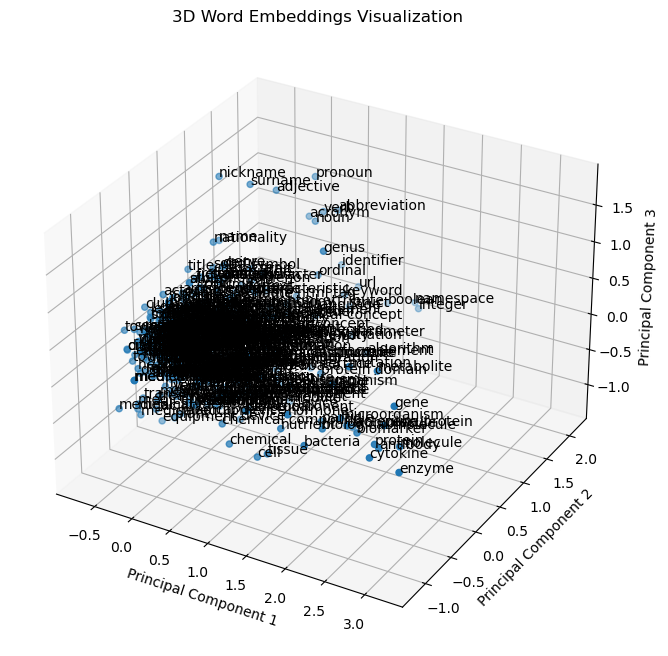

In [29]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(word_emb_3d[:, 0], word_emb_3d[:, 1], word_emb_3d[:, 2])

# Annotate points with word labels (adjust labels accordingly)
for i, word in enumerate(ne_types_list):
    ax.text(word_emb_3d[i, 0], word_emb_3d[i, 1], word_emb_3d[i, 2], word)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Word Embeddings Visualization')

plt.show()

In [30]:
import plotly.express as px

# Create a DataFrame with the 3D embeddings and word labels
data = {'x': word_emb_3d[:, 0], 'y': word_emb_3d[:, 1], 'z': word_emb_3d[:, 2], 'word': ne_types_list}
df = pd.DataFrame(data)

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', text='word', title='3D Word Embeddings Visualization')

# Show the plot
fig.show()

In [31]:
pca = PCA(n_components=2) #Perform 2d-PCA
word_emb_2d = pca.fit_transform(ne_types_embeddings)

import plotly.express as px
# Create a DataFrame with the 2D embeddings and word labels
data = {'x': word_emb_2d[:, 0], 'y': word_emb_2d[:, 1], 'word': ne_types_list}
df = pd.DataFrame(data)

# Create 2D scatter plot using Plotly Express
fig = px.scatter(df, x='x', y='y', text='word', title='2D Word Embeddings Visualization')

fig.show()

# Hierarchical clustering dendogram

In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [14]:
model = AgglomerativeClustering(n_clusters=None, # end when 1 cluster
                                metric='cosine', # cosine is 1-cosine_similarity which means is a measure of dissimilarity, distance measure between [0,2]
                                linkage='average',
                                distance_threshold=0)

In [15]:
print(ne_types_embeddings.shape)

(455, 300)


In [16]:
print(ne_types_list)

['person', 'organization', 'location', 'concept', 'product', 'variable', 'date', 'medical condition', 'object', 'technology', 'chemical', 'software', 'event', 'number', 'disease', 'attribute', 'protein', 'group', 'material', 'measurement', 'other', 'function', 'entity type', 'nationality', 'country', 'class', 'process', 'title', 'animal', 'component', 'condition', 'substance', 'food', 'city', 'activity', 'type', 'company', 'time', 'method', 'property', 'organism', 'drug', 'medical procedure', 'treatment', 'profession', 'cell type', 'anatomical structure', 'job title', 'data', 'quantity', 'sports team', 'biological process', 'data type', 'programming language', 'occupation', 'file', 'body part', 'medical treatment', 'language', 'chemical compound', 'entity', 'gene', 'state', 'law', 'action', 'website', 'library', 'facility', 'publication', 'tool', 'field of study', 'compound', 'document', 'organ', 'abbreviation', 'character', 'brand', 'device', 'operating system', 'service', 'technique'

In [17]:
labels = model.fit_predict(ne_types_embeddings[:, :])

In [18]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Define a custom leaf label function
    def label_leaf_custom(id):
        # id corresponds to cluster index
        if id < n_samples:
            # Singleton leaf, use the label from ne_types_list
            return ne_types_list[id]
        else:
            # Non-singleton cluster
            return f"Cluster {id}, Count: {int(counts[id - n_samples])}"

    plt.figure(figsize=(10, 50))

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', leaf_label_func=label_leaf_custom, leaf_rotation=0, **kwargs)

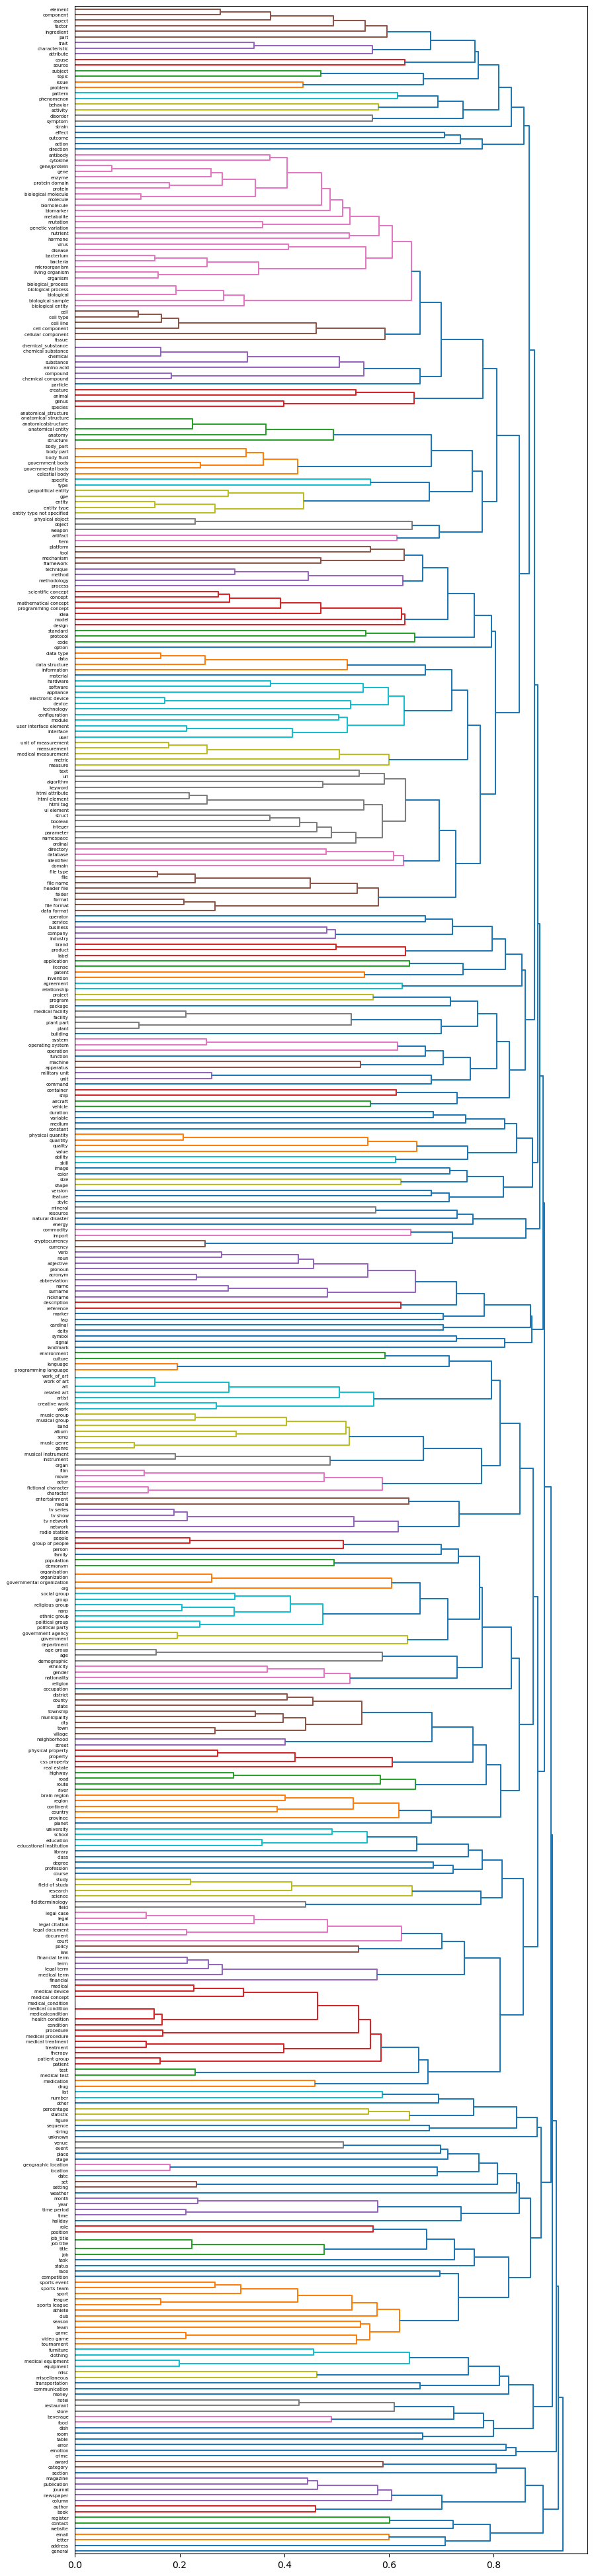

In [21]:
plot_dendrogram(model) # , truncate_mode="level", p=5

In [3]:
new_ne_type_list = {
    "misc": None,
    "miscellaneous": None,
    "other": None,
    "unknown": None,
    "general": None,
    "entity type not specified": None,
    "entity type": None,
    "entity": None,
    "text": None,
    "import": None,
    
    "bacteria": "bacterium",
    "biological": "biological entity",
    "cell": "cell type",
    "cellular component": "cell component",
    "governmental body": "government body",
    "movie": "film",
    "work": "work of art",
    "musical group": "music group",
    "org": "organization",

    "anatomical_structure": "anatomical structure",
    "anatomicalstructure": "anatomical structure",
    "biological_process": "biological process",
    "body_part": "body part",
    "gpe": "geopolitical entity",
    "gene/protein": "gene",
    "work_of_art": "work of art",
    "job_title": "job title",
    "organisation": "organization",
    "chemical_substance": "chemical substance",
    "medical_condition": "medical condition",
    "medicalcondition": "medical condition",

    "fieldterminology": None,
    "cryptocurrency": "cryptocurrency",
    "demonym": "demonym",
    "norp": "norp"
}

In [4]:
# checking all key, values are in NE types list
for k,v in new_ne_type_list.items():
    if k not in ne_types_list:
        print(k)
    if v is not None and v not in ne_types_list:
        print(v)

In [5]:
remapped_ne_type_list = []
for ne_type in ne_types_list:
    if ne_type in new_ne_type_list:
        ne_type = new_ne_type_list[ne_type]  # new NE name or None if to be removed
    if ne_type is not None:
        remapped_ne_type_list.append(ne_type)
remapped_ne_type_list = list(set(remapped_ne_type_list))

In [6]:
print(len(remapped_ne_type_list))

423


### REMOVING NEs in MIT and CrossNER

In [7]:
tagName_to_remove_list = [
    "actor", "character", "genre", "song", "year",  # MOVIE, title left
    "dish", "restaurant",  # RESTAURANT
    "algorithm", "field", "metric", "product", "programming language", "task", "university",  # AI
    "award", "book", "event", "genre", "magazine",  # LITERATURE
    "album", "award", "band", "artist", "instrument", "music genre", "genre", "song",  # MUSIC
    "event", "political party",   # POLITICS
    "journal", "object", "chemical compound", "chemical", "element", "enzyme", "event",  # SCIENCE
    "company", "legal" # BUSTER
]  

tagName_to_remove_list = list(set(tagName_to_remove_list))

In [12]:
pileNER_391_ne_type_list = list(set(remapped_ne_type_list) - set(tagName_to_remove_list))
assert len(pileNER_391_ne_type_list) == 391
print(len(pileNER_391_ne_type_list))

391


In [58]:
from gensim.models import KeyedVectors

ne_types_embeddings = np.array([get_embedding_for_ne(all_pretrained_word_embeddings, ne, ne_mapping) for ne in pileNER_391_ne_type_list])

ne_embeddings_keyedvector = KeyedVectors(vector_size=ne_types_embeddings.shape[-1], count=ne_types_embeddings.shape[0])
for ne_name, ne_emb in zip(ne_types_list, ne_types_embeddings):
    ne_embeddings_keyedvector.add_vector(key=ne_name, vector=ne_emb)

"of" not found while processing ne: "work of art", will be skipped
"of" not found while processing ne: "group of people", will be skipped
"of" not found while processing ne: "field of study", will be skipped
"of" not found while processing ne: "unit of measurement", will be skipped


In [114]:
topics = [
    "biology",
    "medicine",
    "chemistry",
    "informatics", 
    "music",
    "art",
    "science",
    "entertainment",
    "history",
    "geography",
    "religion",
    "law",
    "finance",
    "sports",
    "society",
    "cusine",
    "education",
    "politics",
    "transportation",
    "literature",
    "artificial intelligence"
]

In [62]:
for topic in topics:
    if get_embedding_for_ne(all_pretrained_word_embeddings, topic, None) is None:
        print(topic)

topics_embeddings = np.array([get_embedding_for_ne(all_pretrained_word_embeddings, topic, None) for topic in topics])
print(topics_embeddings.shape)

topics_keyedvector = KeyedVectors(vector_size=topics_embeddings.shape[-1], count=topics_embeddings.shape[0])
for topic, embedding in zip(topics, topics_embeddings):
    topics_keyedvector.add_vector(key=topic, vector=embedding)

(21, 300)


In [74]:
def retrieve_NEs_belonging_to_topic(topics_embeddings, all_words_embeddings_kv, my_NE_kv, top_k=10):
    
    # get the word embeddings for the query words
    #query_emb = all_words_embeddings_kv[query_words_list] # shape: |Q| x 300
    
    # get cosine similarity between queries and my NE embeddings
    cos_sim = cosine_similarity(topics_embeddings, my_NE_kv.vectors) # shape: |Q| x |V_r|=455

    # sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|

    # delete self-similarity, i.e. cos_sim(w,w)=1.0 
    nn_filtered = nn[:, 1:] # remove self_similarity
    
    nn_words = np.array(my_NE_kv.index_to_key)[nn_filtered][:, :top_k]
    
    return nn_words

In [75]:
queries_embeddings = topics_embeddings
top_k = 30
res = retrieve_NEs_belonging_to_topic(queries_embeddings, all_pretrained_word_embeddings, ne_embeddings_keyedvector, top_k=top_k)

for topic, associated_NEs in zip(topics, res):
    print(topic)
    print(associated_NEs)
    print("-------------------")

biology
['author' 'government' 'sports league' 'type' 'cardinal' 'dish' 'venue'
 'value' 'error' 'product' 'album' 'geographic location' 'religious group'
 'culture' 'medical term' 'weather' 'directory' 'library' 'resource'
 'education' 'money' 'age group' 'machine' 'natural disaster' 'adjective'
 'age' 'data type' 'date' 'identifier' 'region']
-------------------
medicine
['season' 'village' 'ordinal' 'natural disaster' 'musical group' 'style'
 'magazine' 'adjective' 'currency' 'header file' 'domain'
 'cellular component' 'package' 'team' 'food' 'song' 'treatment'
 'technology' 'crime' 'legal' 'cardinal' 'tissue' 'file name' 'plant part'
 'tournament' 'author' 'patient' 'letter' 'environment' 'religious group']
-------------------
chemistry
['government' 'patient' 'org' 'product' 'weather' 'type'
 'scientific concept' 'marker' 'radio station' 'medical term' 'film'
 'cardinal' 'album' 'genus' 'operation' 'medical condition' 'author'
 'education' 'department' 'gender' 'cell type' 'direc

In [79]:
print(np.vstack((ne_embeddings_keyedvector.vectors, topics_keyedvector.vectors)).shape)

(412, 300)


In [72]:
from sklearn.cluster import KMeans

# Concatenate named entity and topic vectors
all_vectors = np.vstack((ne_embeddings_keyedvector.vectors, topics_keyedvector.vectors))

# Apply K-means clustering
kmeans = KMeans(n_clusters=topics_keyedvector.vectors.shape[0], random_state=0)
kmeans.fit(all_vectors)

# Get cluster labels for named entities
entity_cluster_labels = kmeans.labels_[:len(ne_embeddings_keyedvector.index_to_key)]

# Associate each named entity with its corresponding cluster label
named_entities_with_clusters = {}
for i, entity in enumerate(ne_embeddings_keyedvector.index_to_key):
    named_entities_with_clusters[entity] = entity_cluster_labels[i]


/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [73]:
print(named_entities_with_clusters)

{'person': 14, 'organization': 12, 'location': 1, 'concept': 7, 'product': 5, 'variable': 19, 'date': 5, 'medical condition': 7, 'object': 6, 'technology': 2, 'chemical': 4, 'software': 1, 'event': 6, 'number': 18, 'disease': 7, 'attribute': 1, 'protein': 19, 'group': 8, 'material': 0, 'measurement': 7, 'other': 19, 'function': 7, 'entity type': 1, 'nationality': 8, 'country': 1, 'class': 7, 'process': 19, 'title': 0, 'animal': 20, 'component': 16, 'condition': 7, 'substance': 6, 'food': 2, 'city': 1, 'activity': 6, 'type': 5, 'company': 7, 'time': 1, 'method': 7, 'property': 6, 'organism': 1, 'drug': 7, 'medical procedure': 19, 'treatment': 4, 'profession': 6, 'cell type': 5, 'anatomical structure': 6, 'job title': 7, 'data': 7, 'quantity': 7, 'sports team': 20, 'biological process': 6, 'data type': 2, 'programming language': 7, 'occupation': 1, 'file': 4, 'body part': 6, 'medical treatment': 7, 'language': 15, 'chemical compound': 8, 'entity': 7, 'gene': 5, 'state': 7, 'law': 8, 'act

In [76]:
print([ne for ne, label in named_entities_with_clusters.items() if label == 7])

['concept', 'medical condition', 'disease', 'measurement', 'function', 'class', 'condition', 'company', 'method', 'drug', 'job title', 'data', 'quantity', 'programming language', 'medical treatment', 'entity', 'state', 'action', 'miscellaneous', 'task', 'movie', 'equipment', 'medical test', 'hardware', 'place', 'characteristic', 'field', 'gender', 'phenomenon', 'ethnicity', 'element', 'virus', 'band', 'crime', 'year', 'medical equipment', 'anatomical entity', 'model', 'medical concept', 'building', 'noun', 'county', 'invention', 'business', 'information', 'item', 'duration', 'programming concept', 'protocol', 'resource', 'subject', 'town', 'hormone', 'legal', 'problem', 'disorder', 'issue', 'instrument', 'body_part', 'court', 'effect', 'email', 'actor', 'culture', 'cell component', 'planet', 'gene/protein', 'css property', 'sports event', 'people', 'reference', 'artist', 'source', 'chemical substance', 'furniture', 'metric', 'folder', 'percentage', 'biomarker', 'size', 'role', 'cause',

In [89]:
from scipy.spatial.distance import cosine

# Assuming named_entity_vectors is a KeyedVectors object containing vectors for named entities
# topic_vectors is a KeyedVectors object containing vectors for topics

# Initialize dictionary to store named entities and their assigned topics
named_entities_with_topics = {}

# Iterate over each named entity vector
for entity in ne_embeddings_keyedvector.index_to_key:
    print(entity)
    entity_vector = ne_embeddings_keyedvector[entity]
    
    # Calculate cosine similarity between entity vector and each topic vector
    similarities = {topic: 1 - cosine(entity_vector, topics_keyedvector[topic]) for topic in topics_keyedvector.index_to_key}
    print(similarities)
    # Assign the named entity to the topic with the highest similarity
    assigned_topic = max(similarities, key=lambda k: similarities[k])
    print(assigned_topic)
    named_entities_with_topics[entity] = assigned_topic
    print("----------------")

person
{'biology': 0.1964985430240631, 'medicine': 0.2215215265750885, 'chemistry': 0.1776231825351715, 'informatics': 0.0062805102206766605, 'music': 0.07574725151062012, 'art': -0.0187247134745121, 'science': 0.07710759341716766, 'entertainment': 0.009395516477525234, 'history': 0.04935818165540695, 'geography': -0.04622240364551544, 'religion': 0.15364550054073334, 'law': 0.020787812769412994, 'finance': -0.013460293412208557, 'sports': 0.06758526712656021, 'society': 0.13242436945438385, 'cusine': 0.10621911287307739, 'education': 0.05426160618662834, 'politics': 0.06449014693498611, 'transportation': 0.008678245358169079, 'literature': 0.11316897720098495, 'artificial intelligence': 0.2323208749294281}
artificial intelligence
----------------
organization
{'biology': 0.03919835388660431, 'medicine': 0.0001383283088216558, 'chemistry': 0.07281913608312607, 'informatics': 0.07417000085115433, 'music': 0.0678286924958229, 'art': 0.06511988490819931, 'science': 0.044114336371421814, '

In [84]:
print(named_entities_with_topics)

{'person': 'artificial intelligence', 'organization': 'geography', 'location': 'finance', 'concept': 'education', 'product': 'biology', 'variable': 'cusine', 'date': 'artificial intelligence', 'medical condition': 'transportation', 'object': 'art', 'technology': 'education', 'chemical': 'music', 'software': 'education', 'event': 'society', 'number': 'religion', 'disease': 'finance', 'attribute': 'society', 'protein': 'cusine', 'group': 'literature', 'material': 'sports', 'measurement': 'society', 'other': 'chemistry', 'function': 'artificial intelligence', 'entity type': 'transportation', 'nationality': 'law', 'country': 'society', 'class': 'transportation', 'process': 'cusine', 'title': 'sports', 'animal': 'history', 'component': 'biology', 'condition': 'society', 'substance': 'artificial intelligence', 'food': 'medicine', 'city': 'sports', 'activity': 'informatics', 'type': 'biology', 'company': 'religion', 'time': 'transportation', 'method': 'art', 'property': 'entertainment', 'orga

## Prompting chatgpt for assigning NEs to topics

In [16]:
topics = [
    "biology",
    "medicine",
    "chemistry",
    "mathematics",
    "programming",
    "science",
    "technology", 

    "music",
    "art",
    "entertainment",
    "cusine",

    #"history",
    "geography",

    "religion",
    "law",
    "finance",
    "politics",

    "sports",
    "society",
    "education",
    "transportation",

    "literature",
    "linguistics",
    "quantity"
]

In [13]:
import json
import sys
import os

from openai import OpenAI
from dotenv import load_dotenv
import tiktoken 

# my libraries
sys.path.append("/Users/andrew/ExpertAI/MSEQA_for_NER/src/MSEQA_4_NER")
from data_handlers import data_handler_pileNER
# Load API key from .env
load_dotenv('./.env')
print(os.environ.get('OPENAI_API_KEY') is not None)
client = OpenAI()
gpt_model = "gpt-3.5-turbo-1106"

True


In [137]:
def get_topic_for_ne(named_entity, topics_list, gpt_model_name, max_output_tokens):
    # system message
    system_message = "You are an expert in Named Entity Recognition, designed to output JSON."
    # user prompt
    example_prompt = "You will be given a list of macro topics and a named entity category. Assign the named entity to the macro topic that is most specific to it. Assign the named entity to one topic only. Return a dictionary with 'macro_topic' and 'named_entity' as keys."
    example_prompt += f"\nMacro-topics list: {list(topics_list)};\nNamed Entity: {named_entity}"
    
    # message to send
    messages_to_send = [
    {
        "role": "system",
        "content": system_message
    },
    {
        "role": "user",
        "content": example_prompt
    }
    ]

    print(f"Sending prompt for NE: {named_entity}...")
    for message in messages_to_send:
        print(message['content'])
    
    completion = client.chat.completions.create(
        messages=messages_to_send,
        model=gpt_model_name,
        max_tokens=max_output_tokens,
        response_format={ "type": "json_object" }
    )

    choice = completion.choices[0]
    finish_reason = choice.finish_reason
    message = choice.message.content


    return {"named_entity": named_entity,
            "prompt_length": completion.usage.prompt_tokens,
            "output_length": completion.usage.completion_tokens,
            "gpt_answer": message,
            "finish_reason": finish_reason
            }


In [135]:
message = get_topic_for_ne('disease', topics, gpt_model, max_output_tokens=100)

Sending prompt for NE: disease...
You are an expert in Named Entity Recognition, designed to output JSON.
You will be given a list of macro topics and a named entity category. Assign the named entity to the macro topic that is most appropriate for it. Assign the named entity to one topic only. Return a dictionary with 'macro_topic' and 'named_entity' as keys.
Macro-topics list: ['biology', 'medicine', 'chemistry', 'mathematics', 'programming', 'science', 'music', 'art', 'entertainment', 'cusine', 'history', 'geography', 'religion', 'law', 'finance', 'politics', 'sports', 'society', 'education', 'transportation', 'literature', 'linguistics', 'quantity'];
Named Entity: disease


In [136]:
print(message)

{'named_entity': 'disease', 'prompt_length': 169, 'output_length': 19, 'gpt_answer': '{\n  "macro_topic": "medicine",\n  "named_entity": "disease"\n}', 'finish_reason': 'stop'}


In [ ]:
ne_topic = []
for ne in pileNER_391_ne_type_list:
    try:
        ne_definition = get_topic_for_ne(ne, topics, gpt_model, max_output_tokens=100)
        ne_topic.append(ne_definition)
    except:
        with open(f"./definitions/assigned_topics_err.json", 'w') as f:
            json.dump(ne_topic, f, indent=2)
        print(f"Something went wrong while processing NE: {ne}")

with open(f"./definitions/assigned_topics.json", 'w') as f:
    json.dump(ne_topic, f, indent=2)

In [14]:
with open(os.path.join('./definitions/', 'assigned_topics.json'), 'r') as file:
    gpt_responses = json.load(file)

In [17]:
named_entities_per_topic = {topic: [] for topic in topics}
named_entities_per_topic['UNK'] = []

for item in gpt_responses:
    named_entity = item['named_entity']
    gpt_answer = eval(item['gpt_answer'])
    assigned_topic = gpt_answer['macro_topic']
    if assigned_topic not in topics:
        print(f"{assigned_topic} not in topics list!, from NE: {named_entity}")
        named_entities_per_topic['UNK'].append(named_entity)
    else:
        named_entities_per_topic[assigned_topic].append(named_entity)

sorted_named_entities_per_topic = dict(sorted(named_entities_per_topic.items(), key=lambda item: len(item[1]), reverse=True))

economics not in topics list!, from NE: industry
physics not in topics list!, from NE: particle
architecture not in topics list!, from NE: room
information not in topics list!, from NE: information
psychology not in topics list!, from NE: emotion
calendar not in topics list!, from NE: month
communication not in topics list!, from NE: contact
history not in topics list!, from NE: time period
commerce not in topics list!, from NE: store
physics not in topics list!, from NE: constant
psychology not in topics list!, from NE: behavior
commerce not in topics list!, from NE: brand
psychology not in topics list!, from NE: trait
philosophy not in topics list!, from NE: idea
measurement not in topics list!, from NE: standard
nature not in topics list!, from NE: season
fashion not in topics list!, from NE: style
information technology not in topics list!, from NE: directory
electronics not in topics list!, from NE: signal
history not in topics list!, from NE: artifact
history not in topics list!,

In [142]:
with open(f"./definitions/sorted_assigned_topics.json", 'w') as f:
    json.dump(sorted_named_entities_per_topic, f, indent=2)

## plotting

In [20]:
with open(os.path.join('./definitions/', 'sorted_assigned_topics_fixed.json'), 'r') as file:
    assigned_topics = json.load(file)

In [21]:
for topic, list_nes in assigned_topics.items():
    print(topic, len(list_nes))

biology 40
programming 43
society 34
technology 11
misc 27
science 26
geography 28
medicine 29
education 20
linguistics 19
mathematics 16
entertainment 13
law 12
transportation 12
sports 10
quantity 12
chemistry 8
finance 8
politics 6
art 7
cusine 3
religion 3
literature 3
music 1


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import circlify

In [32]:
data_to_plot = pd.DataFrame({
    #'topics': list(assigned_topics.keys()),
    'topics': [topic + '\n' + str(len(list_nes)) for topic, list_nes in assigned_topics.items()],
    'number_NEs': [len(list_nes) for topic, list_nes in assigned_topics.items()]
})
# Drop rows where topic is 'miscellaneous'
data_to_plot = data_to_plot[data_to_plot['topics'] != 'misc\n27']

# Reverse the order based on the number of NEs
data_to_plot = data_to_plot.sort_values(by='number_NEs', ascending=False).reset_index(drop=True)

In [33]:
print(data_to_plot)

                topics  number_NEs
0      programming\n43          43
1          biology\n40          40
2          society\n34          34
3         medicine\n29          29
4        geography\n28          28
5          science\n26          26
6        education\n20          20
7      linguistics\n19          19
8      mathematics\n16          16
9    entertainment\n13          13
10  transportation\n12          12
11        quantity\n12          12
12             law\n12          12
13      technology\n11          11
14          sports\n10          10
15        chemistry\n8           8
16          finance\n8           8
17              art\n7           7
18         politics\n6           6
19           cusine\n3           3
20         religion\n3           3
21       literature\n3           3
22            music\n1           1


In [34]:
# compute circle positions
circles = circlify.circlify(
    data_to_plot['number_NEs'].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# reverse the order of the circles to match the order of data
circles = circles[::-1]

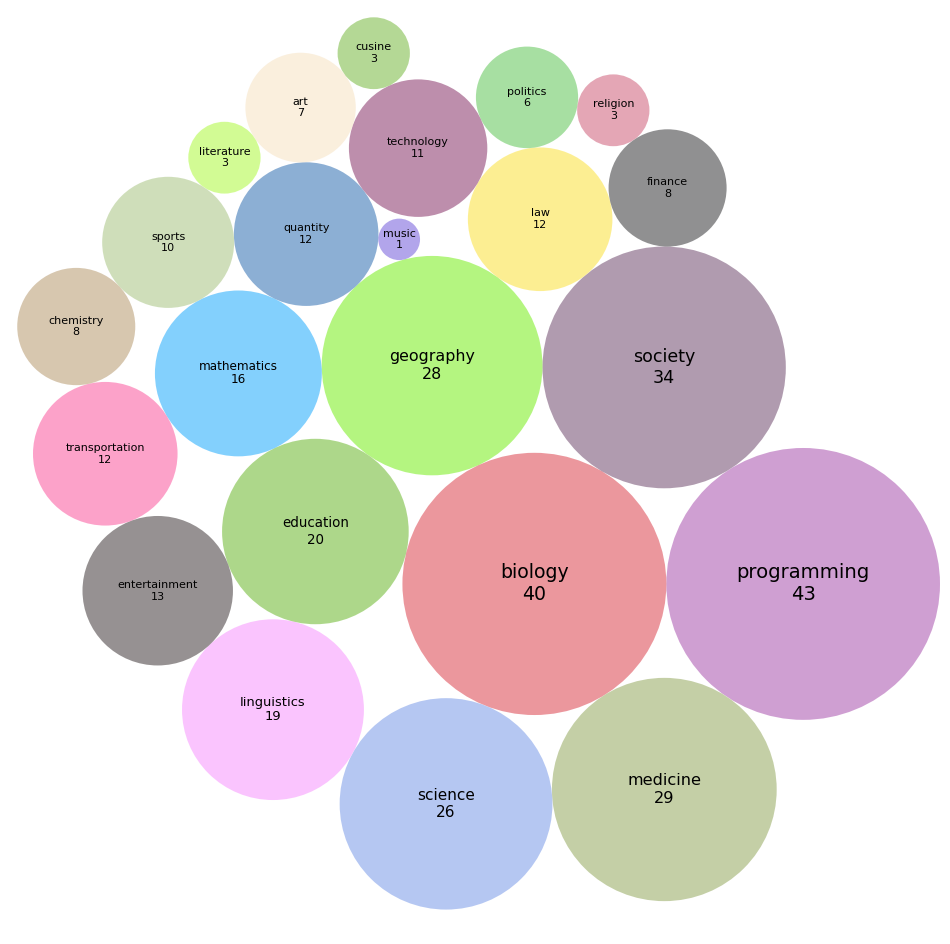

In [265]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(12, 12))

# Title
#ax.set_title('Basic circular packing')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = data_to_plot['topics']

# Random colors
#colors = np.random.choice(list(mcolors.TABLEAU_COLORS.values()), len(circles), replace=True)
colors = np.random.rand(len(circles), 3)

def get_font_size(radius, min_size=8, max_size=20):
    return max(min_size, min(max_size, radius * 50))


# print circles
for circle, label, color in zip(circles, labels, colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=0, color=color))
    plt.annotate(
        label,
        (x, y),
        va='center',
        ha='center',
        fontsize=get_font_size(r)
    )

plt.savefig('./macro-topics.pdf', dpi=300, bbox_inches='tight')
plt.show()
